# **Исследование компьютерных игр**

Цель: проанализировать открытые исторические данные о компьютерных играх и выявить закономерности, которые способствуют успешности игр на рынке

План исследования:

1. Общая информация
2. Предобработка данных
3. Исследовательский анализ данных
4. Составление портретов пользователей регионов

 4.1 Топ-5 самых популярных платформ
 
 4.2 Топ-5 самых популярных жанров
 
 4.3 Популярность по категориям рейтинга ESRB

5. Проверка гипотез

 5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

 5.2 Средние пользовательские рейтинги жанров Action и Sports разные

6. Общий вывод 

### **1. Общая информация**

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt

Открываем датасет

In [2]:
data = pd.read_csv('games.csv')

Посмотрим первые пять строк датасета

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Изучим общую информацию

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Посмотрим на гистограммах сырые данные

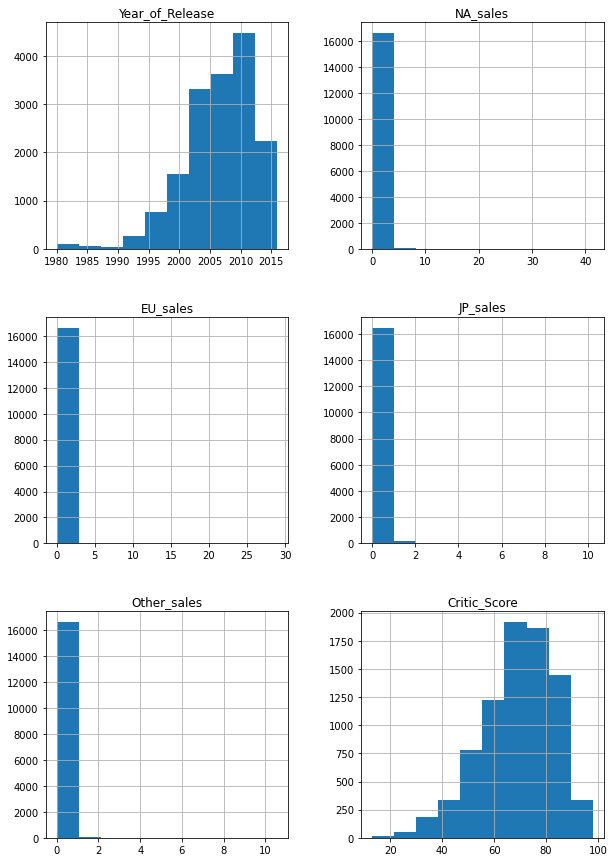

In [5]:
data.hist(figsize=(10, 15));

Каких-либо бросающихся в глаза аномалий на гистограммах нет

Вывод: первый обзор данных показал, что необходимо поработать с пропусками, изменить тип данных в некоторых колонках для дальнейшей работы, а также провести проверку на наличие дубликатов игровых платформ

### **2. Предобработка данных**

Приведём к нижнему регистру названия столбцов

In [6]:
columns = ['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales', 'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating']
for i in columns:
  data = data.rename(columns={
      i: i.lower()
      })

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Преобразуем тип данных в столбце даты релиза игры для удобства работы

Заполнять пропуски в колонке даты релиза не будем, так как это категориальные данные и мы не можем их заполнить медианным или средним значением. Возможно, пропуски в этом столбце возникли вследствие ошибки при выгрузке данных.

Преобразовывать тип данных здесь же тоже не имеет смысла, ведь нам интересен только год выпуска игры, а значит можно оставить столбец в исходном варианте

Удаляем две строчки с пропусками в колонке с названием игры и жанром, так как без этих сведений они не представляют аналитической ценности, к тому же количество удаляемых данных существенно не повлияет на общую картину исследования

In [8]:
data = data.dropna(subset=['name'])

По этой же причине удалим пропуски в столбце с годом релиза

In [9]:
data = data.dropna(subset=['year_of_release'])

Заполнять пропуски в столбцах с оценками критиков и пользователей не будем, так как это напрямую может повлиять на результаты анализа и исказить имеющиеся данные. Такие пропуски возможны из-за того, что оценки пока ещё не проставлены или игра не подвергалась оценке. Соответственно, делать выводы и проверять гипотезы по таким играм, можно лишь опираясь на фактически имеющиеся данные

Пропуски в колонке с рейтингом по возрастным ограничениям заполним значением "неизвестен", так как это категориальные данные. как и в случае с годом релиза. Возможно, пропуски в этом столбце появились по причине отсутствия этой оценки у конкретных игр или вследствие ошибки при выгрузке данных

In [10]:
data['rating'] = data['rating'].fillna('unknown');

Колонка с оценками пользователей содержит аббревиатуру 'tbd', которая означает, что оценка ещё не выставлена, но будет в дальнейшем. В нашем случае, для того, чтобы обработать данные из этого столбца, необходимо перевести эти значения в пропуски и затем изменить тип данных столбца для работы с вещественными числами

In [11]:
data = data.replace('tbd', 'NaN')
data['user_score'] = data['user_score'].astype('float')
data['user_score'].describe()

count    7463.000000
mean        7.126330
std         1.499447
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

Проверим датасет на явные дубликаты

In [12]:
data.duplicated().sum()

0

Проверка на неявные дубликаты показала, что дубликатов платформ нет

In [13]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Добавим колонку 'total_sales', в которой отобразим совокупность продаж всех регионов

In [14]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


Вывод: датасет содержит много пропусков в колонках с оценками и рейтингом. Мы обработали их необходимым образом. Затем сделали проверку на наличие явных и неявных дубликатов и создали дополнительный столбец с общим количеством проданных копий игр по всем регионам. Можем приступать к анализу

### **3. Исследовательский анализ данных**

Посмотрим, сколько игр выпускалось в разные годы

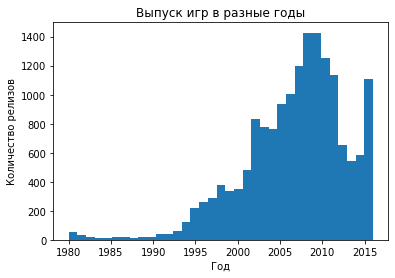

In [15]:
fig, ax = plt.subplots()
ax.hist(data['year_of_release'], bins = 35)
ax.set_title('Выпуск игр в разные годы')
ax.set_xlabel('Год')
ax.set_ylabel('Количество релизов')
plt.show()

Как видно из графика, до 1995 года игр выпускалось существенно меньше, чем после него. Это означает, что с точки зрения объёма аналитические данные до 1995 года не являются очень важными, поэтому для прогноза возьмём данные с 1995 года

In [16]:
good_data = data.query('year_of_release >= 1995')

Теперь посмотрим, у каких игровых платформ наибольшее количество продаж за все периоды

In [17]:
good_data.groupby('platform')['total_sales'].agg(['sum']).sort_values(by='sum', ascending=False)

,sum
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,721.55
PS4,314.14
GBA,312.88
PSP,289.53


Возьмём первые 6 платформ с самым большим количеством продаж и посмотрим график их распределения по годам

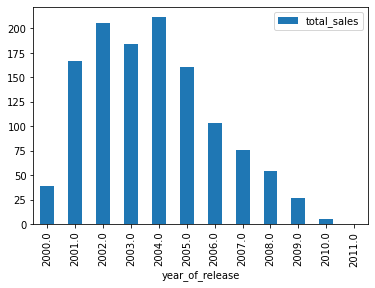

In [18]:
good_data.query('platform == "PS2"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(y='total_sales', kind='bar');

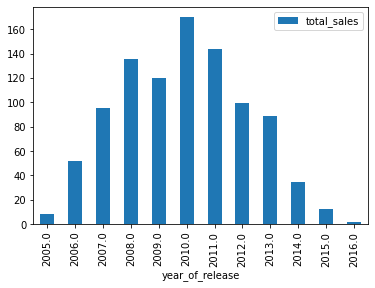

In [19]:
good_data.query('platform == "X360"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(y='total_sales', kind='bar');

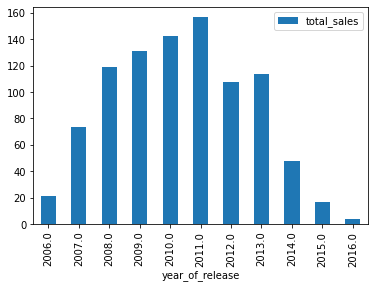

In [20]:
good_data.query('platform == "PS3"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(y='total_sales', kind='bar');

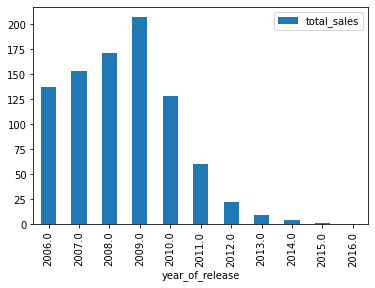

In [21]:
good_data.query('platform == "Wii"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(y='total_sales', kind='bar');

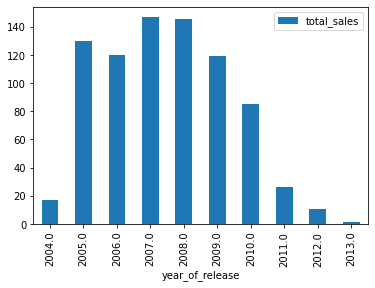

In [22]:
good_data.query('platform == "DS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(y='total_sales', kind='bar');

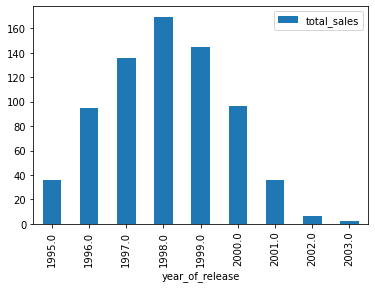

In [23]:
good_data.query('platform == "PS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(y='total_sales', kind='bar');

Исходя из графиков, мы видим, что в среднем платформа актуальна 10-11 лет, затем она исчезает. При этом новые платформы появляются примерно каждые 5 лет.
Лидирует по продажам PS2, однако эта платформа довольно стара и ещё в 2011 перестала приносить доход. Следом идут X360 и PS3, однако они уже находятся на спаде, начиная с 2014 года

Чтобы определить потенциально прибыльные платформы, отфильтруем наши данные и включим лишь выборку с 2014 года, так как этот период является актуальным для прогноза на 2017 год

In [24]:
good_data.query('year_of_release >= 2014').groupby('platform')['total_sales'].agg(['sum']).sort_values(by='sum', ascending=False)

,sum
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05
PSV,22.40
Wii,5.07


Как видим, лидеры изменились. Посмотрим на графиках, какой тренд по продажам у первых двух платформ

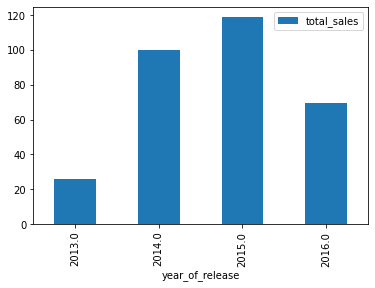

In [25]:
good_data.query('platform == "PS4"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(y='total_sales', kind='bar');

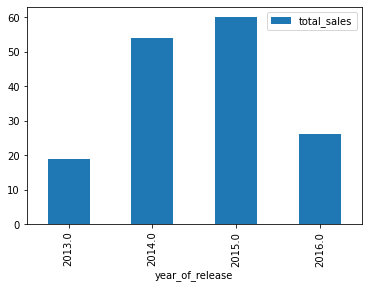

In [26]:
good_data.query('platform == "XOne"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(y='total_sales', kind='bar');

Видим, что тренд по продажам у этих платформ восходящий, а значит, их можно считать потенциально прибыльными

Отсечём неактуальные данные и оставим только с 2014 года 

In [27]:
actual_data = data.query('year_of_release >= 2014')

Построим диаграммы размаха продаж (в миллионах копий) для каждой платформы с 2014 года

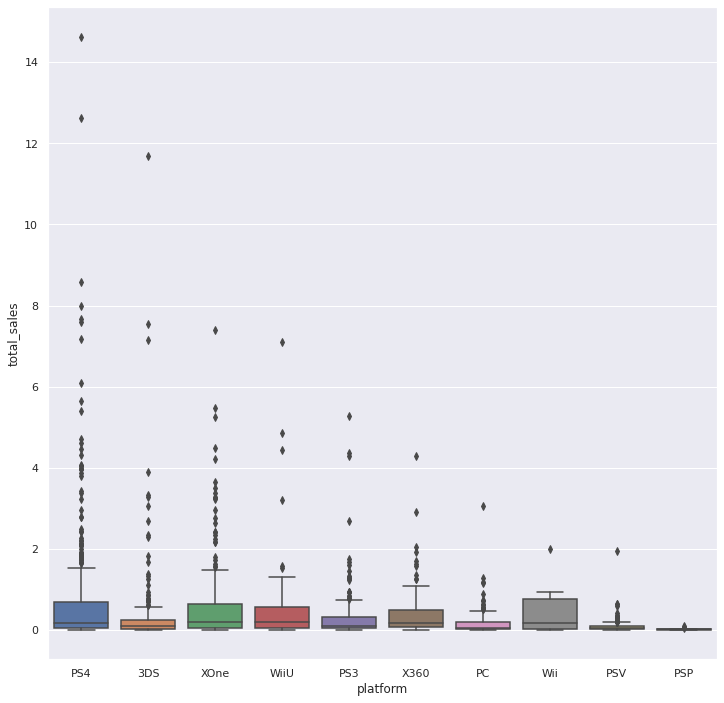

In [28]:
sns.set(rc={"figure.figsize":(12, 12)});
sns.boxplot(data=actual_data, x='platform', y='total_sales');

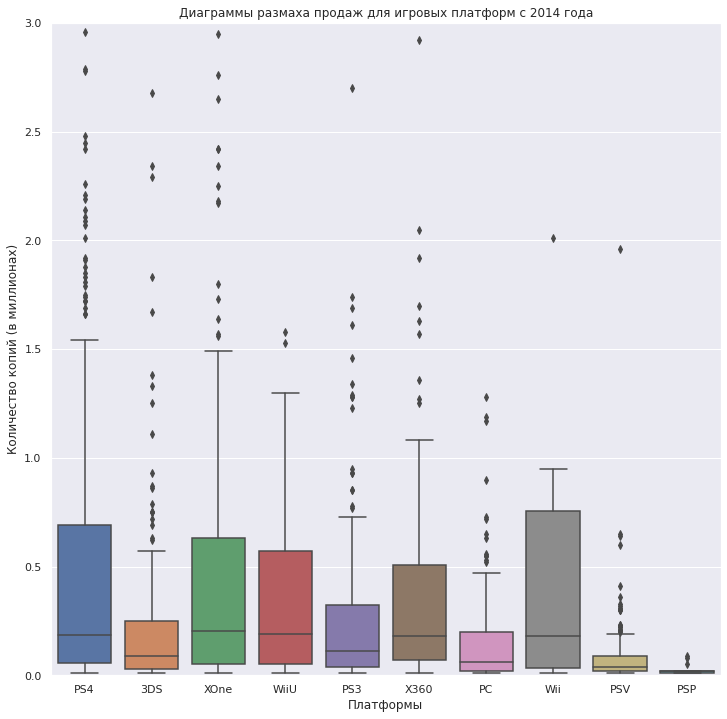

In [29]:
fig, ax = plt.subplots()
sns.boxplot(data=actual_data, x='platform', y='total_sales')
ax.set_title('Диаграммы размаха продаж для игровых платформ с 2014 года')
ax.set_xlabel('Платформы')
ax.set_ylabel('Количество копий (в миллионах)')
plt.ylim(0, 3)
plt.show()

Как видно из графиков, характерные разбросы больше всего у платформ "PS4" и "XOne". Это означает, что на этих платформах продаётся стабильно больше игр, чем на других. Платформа "Wii" имеет самый большой третий квартиль среди всех платформ, однако, исходя из предыдущих расчётов, на этой платформе вышло слишком мало игр, чтобы она могла претендовать на лидерство по популярности и количеству копий

Построим диаграмму рассеяния для самой популярной актуальной платформы и посмотрим зависимость между оценками пользователей и критиков и количеством продаж

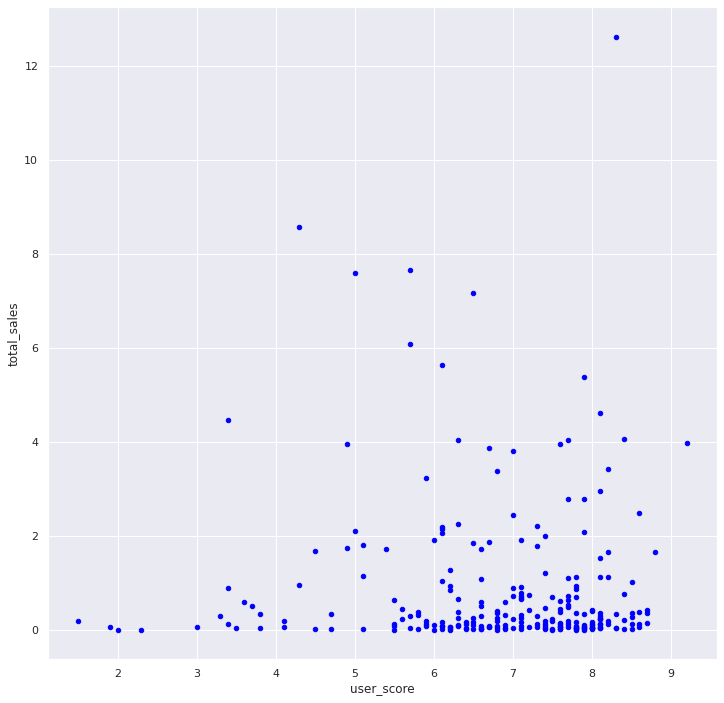

In [30]:
actual_data.query('platform == "PS4"').plot(x='user_score', y='total_sales', kind='scatter', color='blue');

Из графика видно, что много игр получают оценку выше 5, однако это не является залогом большого количества продаж. Но и залогом маленького количества тоже  нет, так как есть игры с количеством продаж на хорошем уровне. Игры с самым большим количеством продаж имеют средние оценки от 4 до 7

In [31]:
actual_data.loc[actual_data['platform'] == 'PS4', 'user_score'].corr(actual_data['total_sales'])

-0.040131589472697356

Расчёт корреляции подтверждает то, что в данной ситуации она практически отсутствует

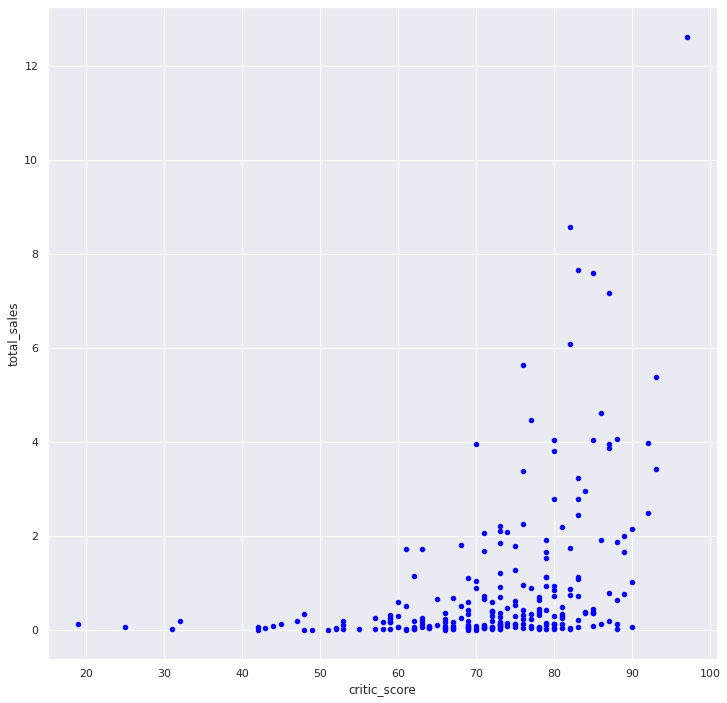

In [32]:
actual_data.query('platform == "PS4"').plot(x='critic_score', y='total_sales', kind='scatter', color='blue');

На данном графике видно, что чем выше оценка критиков, тем больше количество проданных копий. Это относится не ко всем играм, но в целом, тенденция отчётливо наблюдается

In [33]:
actual_data.loc[actual_data['platform'] == 'PS4', 'critic_score'].corr(actual_data['total_sales'])

0.40266141068104083

Расчёт корреляции подтверждает наблюдение на графике: связь не сильная, но существует

Сравним полученные данные с данными по остальным платформам

WiiU
0.40792645792170773
0.370201412480884


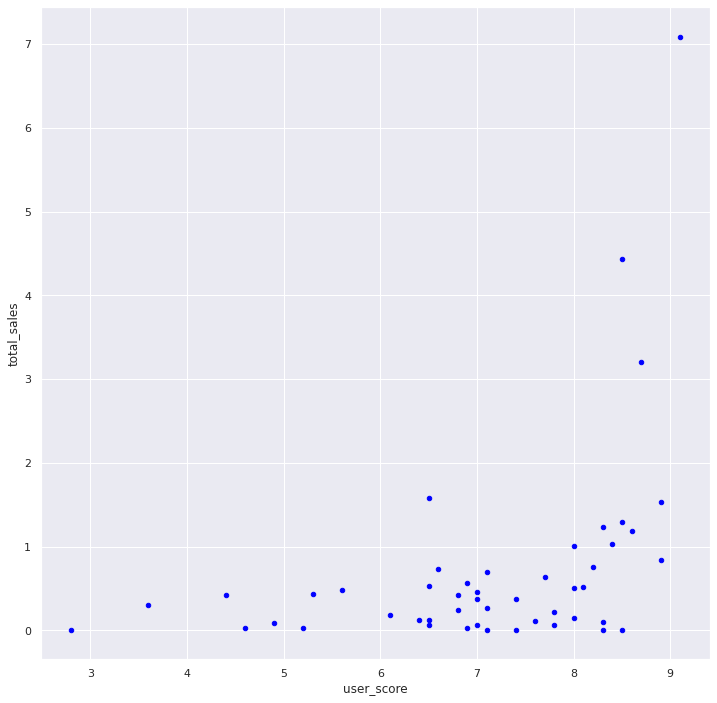

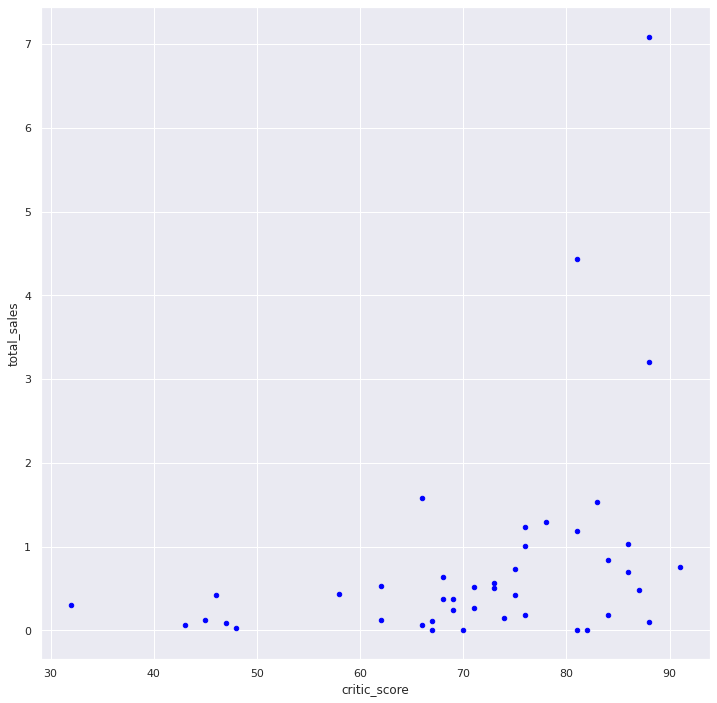

XOne
-0.0703839280647581
0.42867694370333226


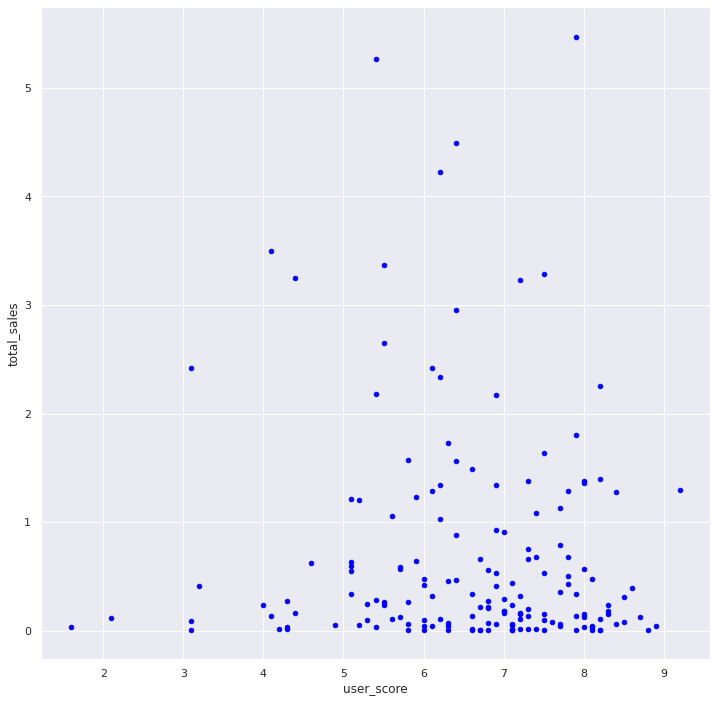

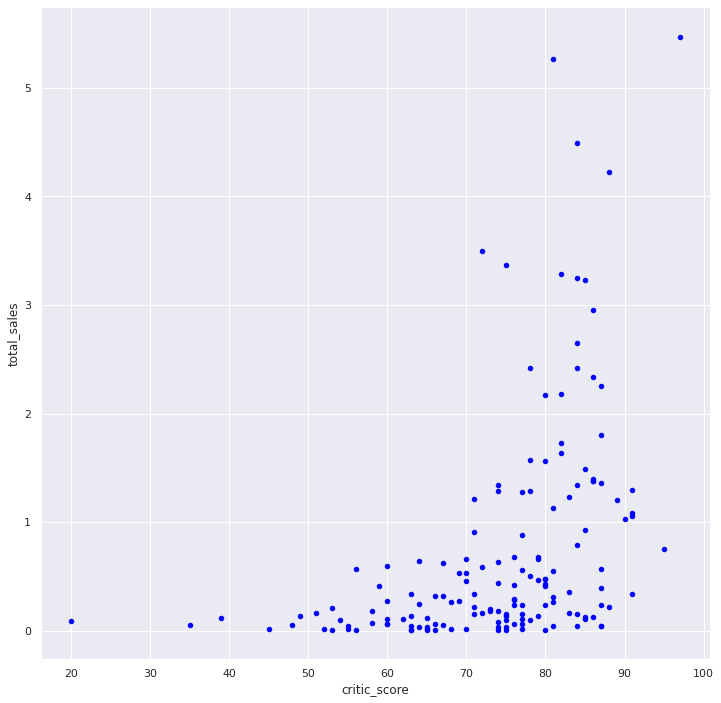

PS3
-0.16676141347662118
0.44657460493190704


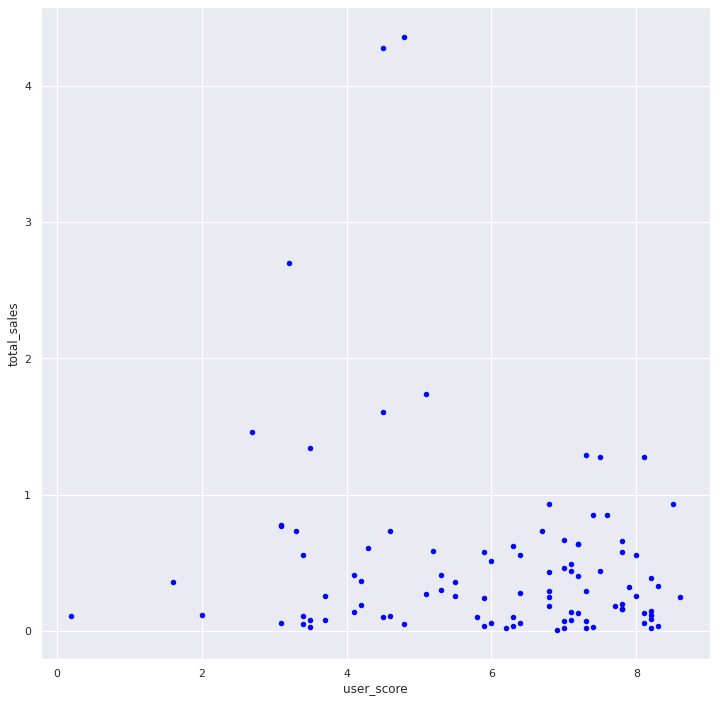

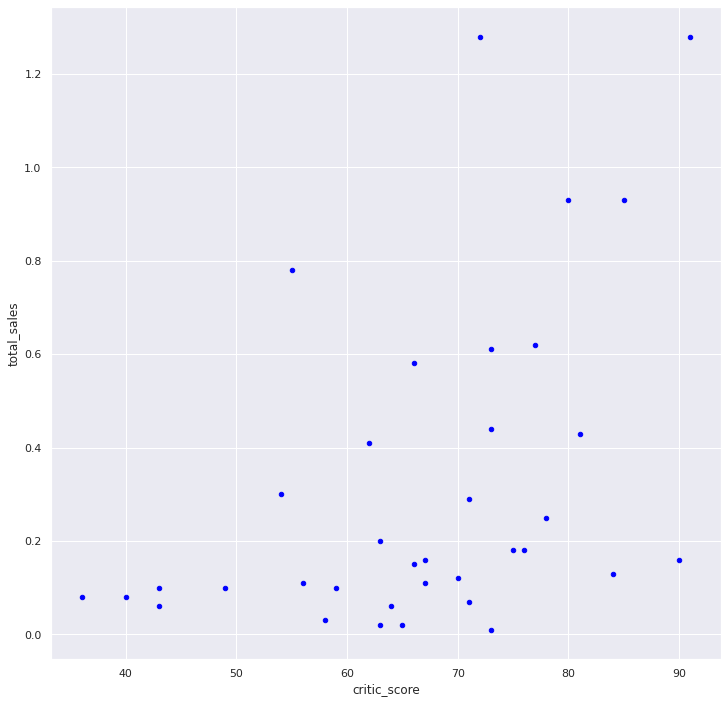

X360
-0.138444570945665
0.5257228356581523


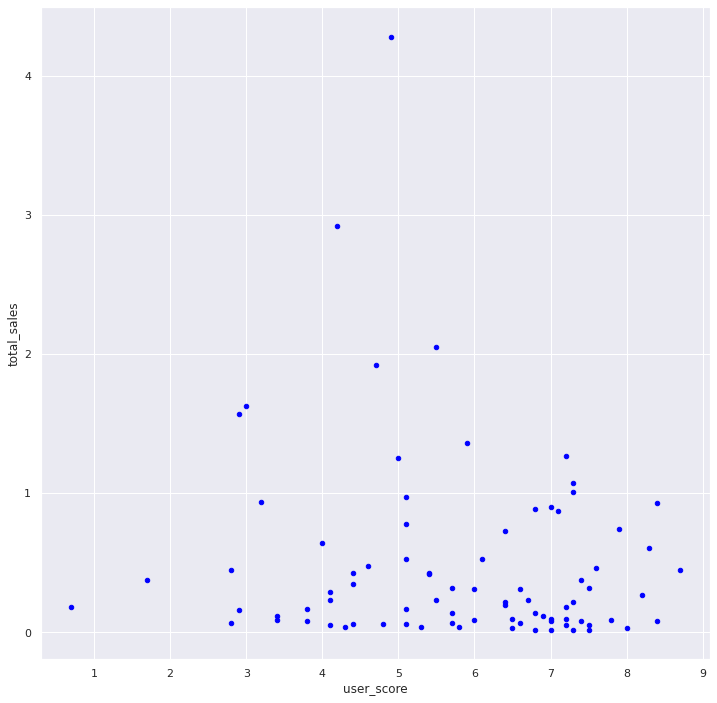

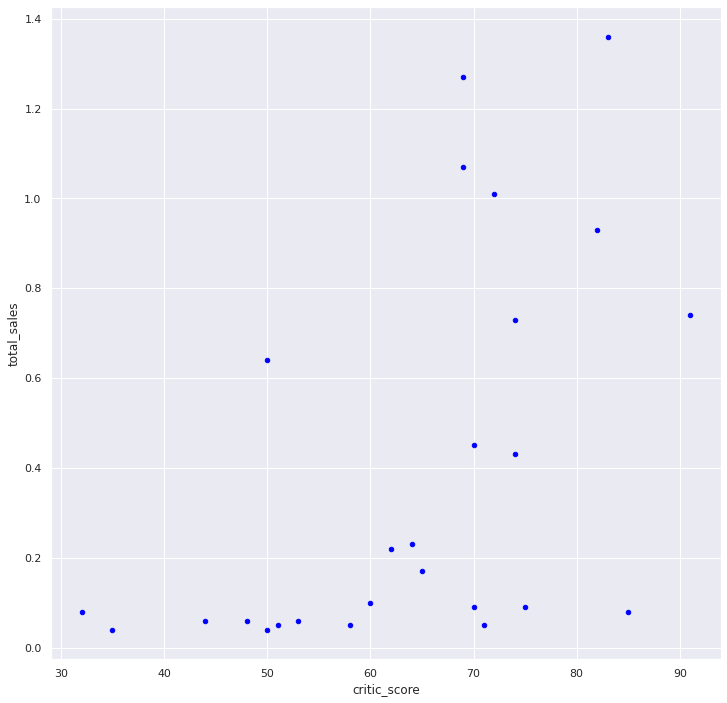

3DS
0.2151932718527028
0.314117492869051


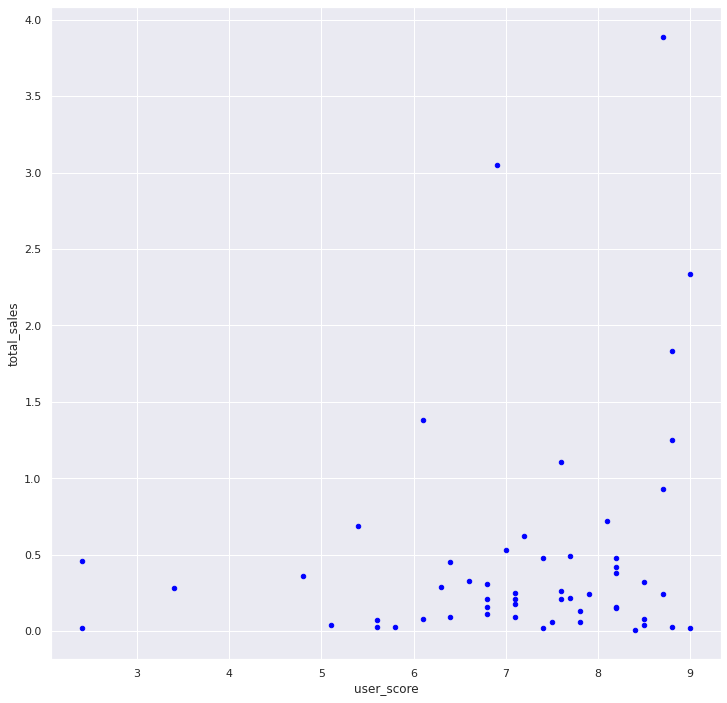

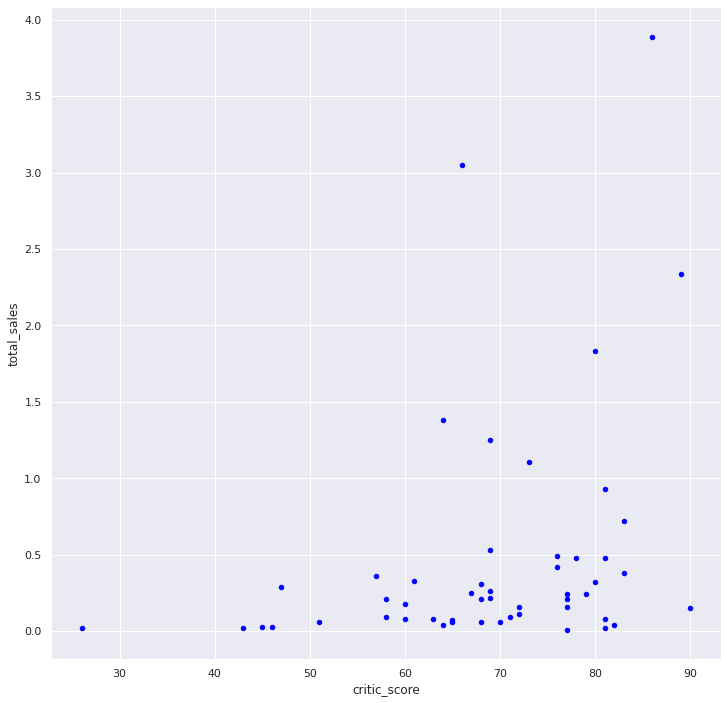

In [34]:
platforms = ['WiiU', 'XOne', 'PS3', 'X360', '3DS']

for platform in platforms:
    print(platform)
    actual_data.query('platform == @platform').plot(x='user_score', y='total_sales', kind='scatter', color='blue');
    print(actual_data.loc[actual_data['platform'] == platform, 'user_score'].corr(actual_data['total_sales']))
    
    actual_data.query('platform == @platform').plot(x='critic_score', y='total_sales', kind='scatter', color='blue');
    print(actual_data.loc[actual_data['platform'] == platform, 'critic_score'].corr(actual_data['total_sales']))
    plt.show()

Как видно из полученных данных, корреляция оценок по платформам разная. Платформа "WiiU" и "3DS" имеет слабую корреляцию и по оценкам пользователей, и по оценкам критиков. Платформы "XOne" и "PS3" имеют отрицательную корреляцию по оценкам пользователей, но она практически отсутствует. При этом есть слабо выраженная корреляция продаж и оценок критиков. Платформа "X360" имеет среднюю корреляцию продаж с оценками критиков. В целом можно сказать, что, как и в случае с лидером, пользовательские оценки практически не коррелируют с количеством продаж, а вот между оценками критиков и продажами связь хоть и слабая, но существует

Посмотрим, как распределяются продажи в зависимости от жанров

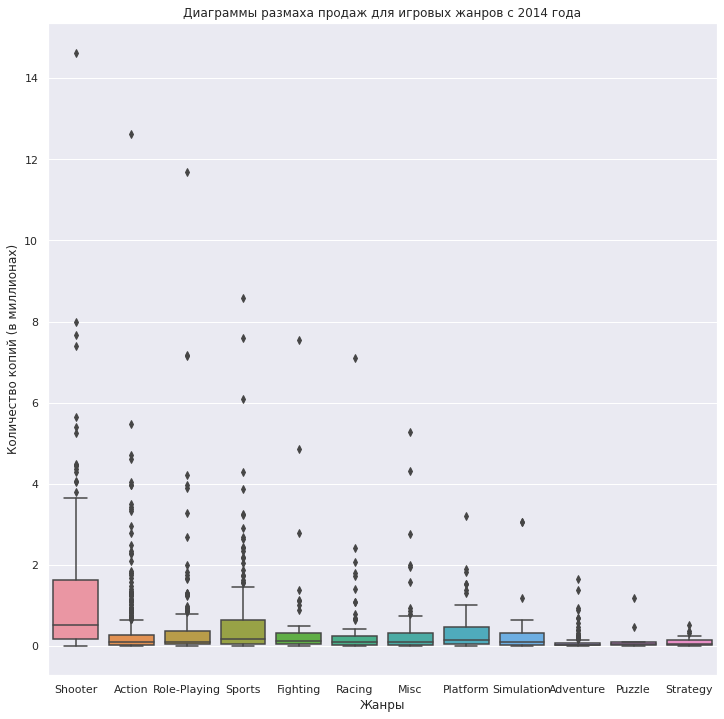

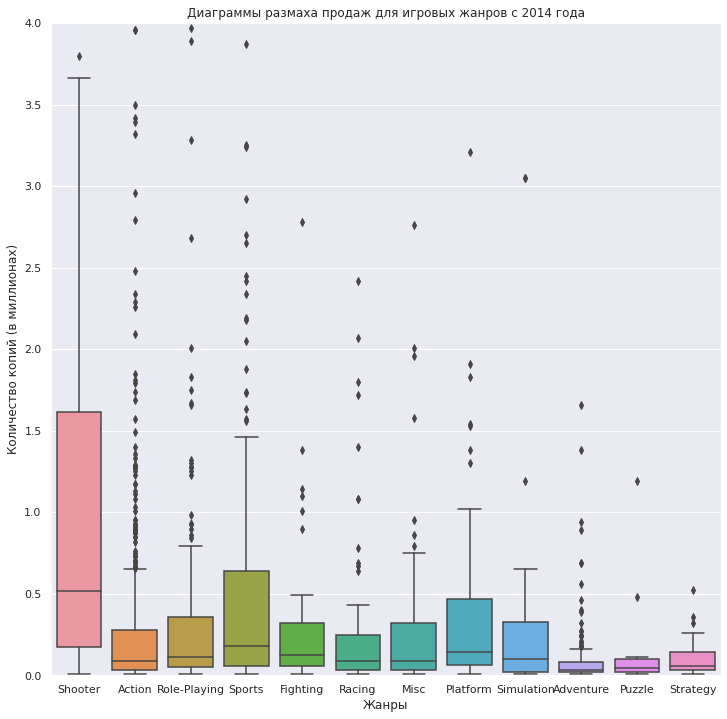

In [35]:
fig, ax = plt.subplots()
sns.boxplot(data=actual_data, x='genre', y='total_sales')
ax.set_title('Диаграммы размаха продаж для игровых жанров с 2014 года')
ax.set_xlabel('Жанры')
ax.set_ylabel('Количество копий (в миллионах)')
plt.show()

fig, ax = plt.subplots()
sns.boxplot(data=actual_data, x='genre', y='total_sales')
ax.set_title('Диаграммы размаха продаж для игровых жанров с 2014 года')
ax.set_xlabel('Жанры')
ax.set_ylabel('Количество копий (в миллионах)')
plt.ylim(0, 4)
plt.show()

Как видим, несмотря на 'выбросы' очень продаваемых единичных игр в жанре "Action", наиболее стабильно продаваемыми, исходя из характерного разброса и медианных значений, являются жанры "Shooter" и "Sports"

Вывод: до 1995 года объём рынка компьютерных игр был невелик. Затем количество выпускаемых игр стало расти вплоть до 2010-х. При этом жизненный цикл игровой платформы составляет примерно 10-11 лет, а новые платформы появляются в среднем каждые 5 лет. Исходя из этого, мы сократили выборку до данных с 2014 года по настоящее время для того, чтобы сделать качественный прогноз на 2017 год. В ходе исследования мы выяснили потенциально прибыльные платформы, и посмотрели характерные разбросы в продажах. Затем определили, что влияние пользовательских оценок на продажи игр практически отсутствует, а вот на оценки критиков всё-таки обращают внимание при покупке игр, судя по имеющейся корреляции этих данных

### **4. Составление портретов пользователей регионов**

**4.1 Топ-5 самых популярных платформ**

Определим самые популярные платформы для каждого из регионов

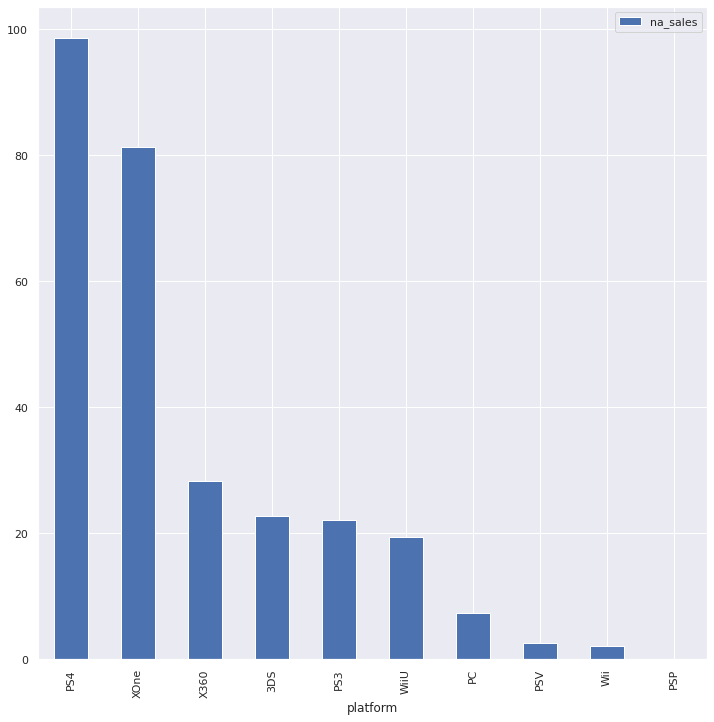

In [36]:
actual_data.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).plot(y='na_sales', kind='bar');

В данном регионе два лидера совпадают с общим рейтингом, причём доля их продаж значительно опережает остальные платформы

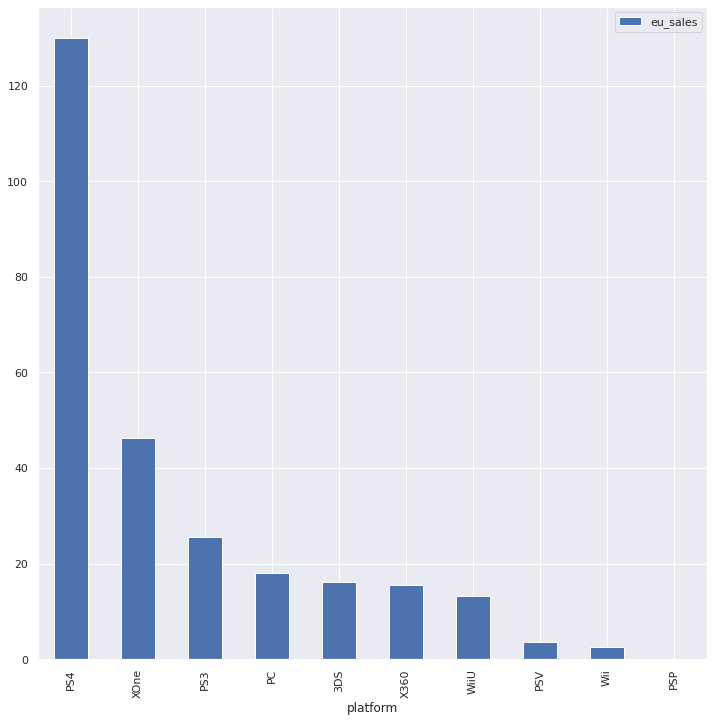

In [37]:
actual_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).plot(y='eu_sales', kind='bar');

В Европе, по сравнению с Северной Америкой, лидер "PS4" ещё сильнее отрывается по доле продаж от конкурента "XOne", а в пятёрку на 4-е место врывается персональный компьютер, вытесняя "X360"

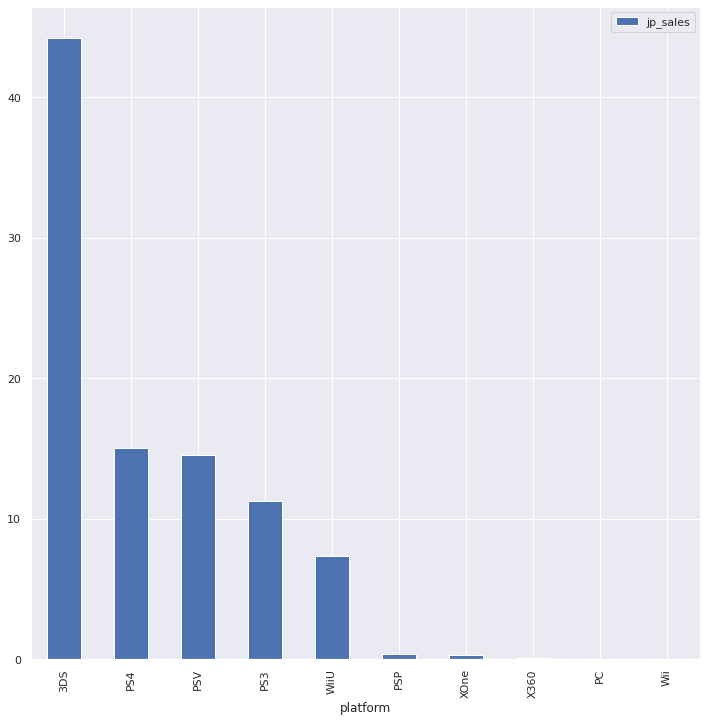

In [38]:
actual_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).plot(y='jp_sales', kind='bar');

В Японии кардинальные изменения. Топ-5 с большим отрывом возглавляет платформа "3DS", затем идут "PS4", "PSV" и "PS3" с объёмом продаж примерно от 11 до 15 млн копий у каждой. Замыкает пятёрку платформа "WiiU"

**4.2 Топ-5 самых популярных жанров**

Далее определим самые популярные жанры по регионам

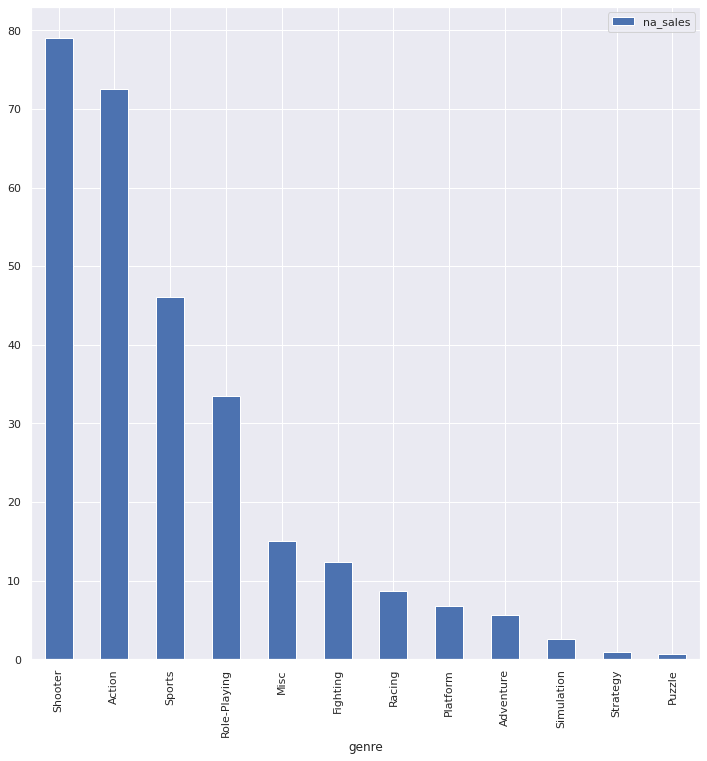

In [39]:
actual_data.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).plot(y='na_sales', kind='bar');

В Северной Америке более популярны шутеры, чем экшен. Также в топе спорт, ролевые игры и смешанный жанр

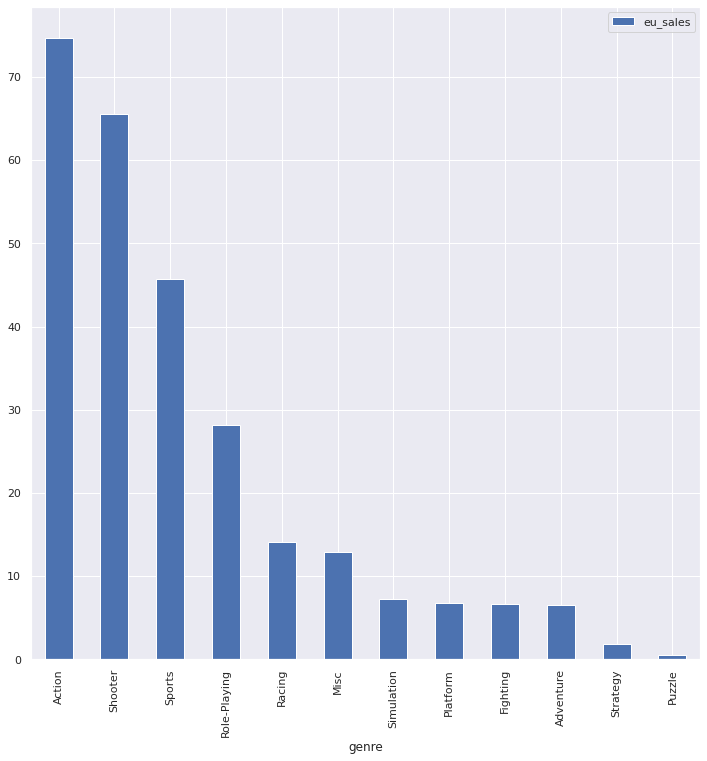

In [40]:
actual_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).plot(y='eu_sales', kind='bar');

В Европе экшен обходит шутеры с примерно одинаковые разрывом в доле продаж, как и в Америке. Спортивные и ролевые игры так же на 3-м и 4-м месте соответственно. Гонки на пятом

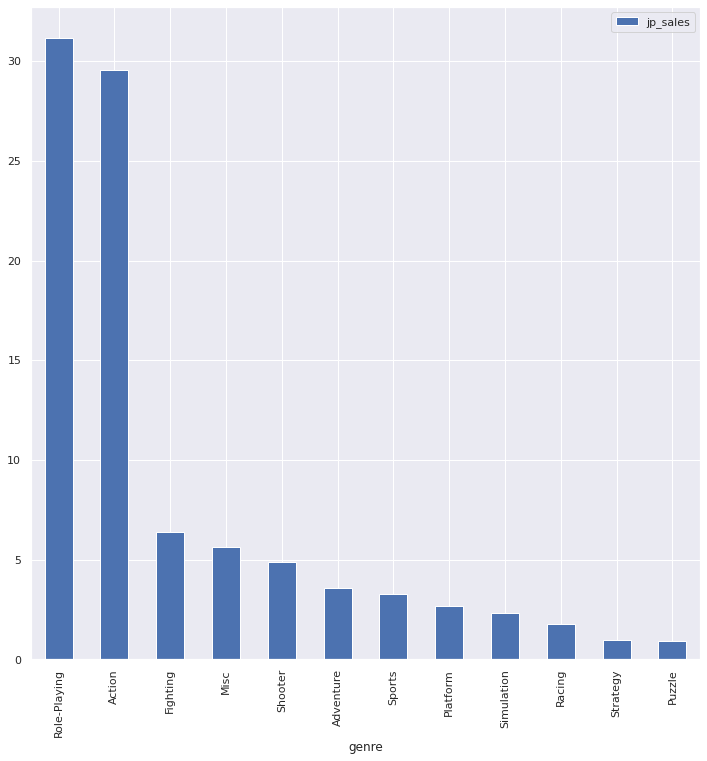

In [41]:
actual_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).plot(y='jp_sales', kind='bar');

В Японии на первом месте ролевые игры. Это неудивительно, так как в Японии этот жанр давно является самым популярным. Даже есть отдельный поджанр RPG - JRPG со своими стилевыми особенностями. Затем идёт экшен с небольшим отставанием в доле продаж. На последующих местах файтинг, смешанный жанр и шутеры соответственно. Продажи этих жанров составляют в районе 5 млн копий каждого

**4.3 Популярность по категориям рейтинга ESRB**

Далее проверим, насколько влияет рейтинг ESRB на продажи в отдельных регионах

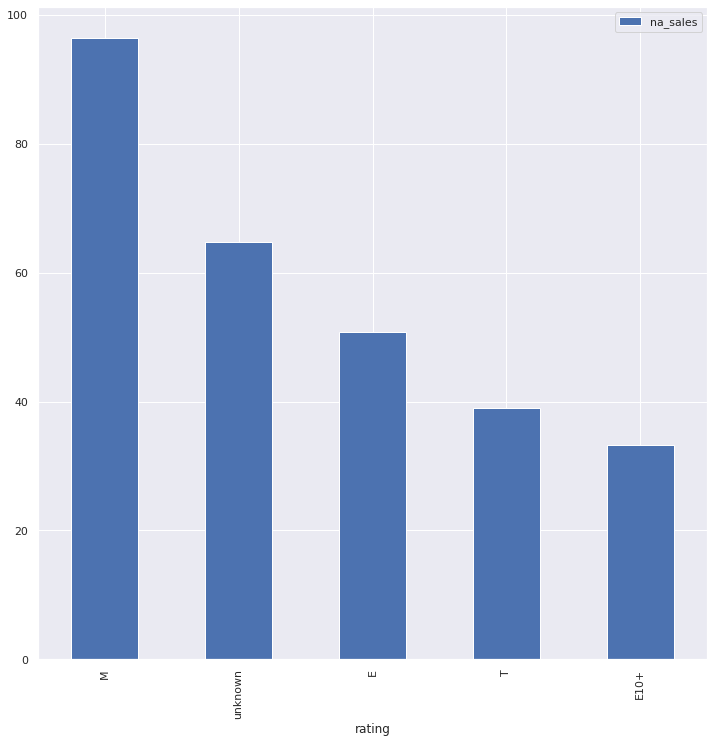

In [42]:
actual_data.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).plot(y='na_sales', kind='bar');

В Северной Америке самые популярные игры категории "для взрослых". Относительно непопулярные - игры «для всех от 10 лет и старше»

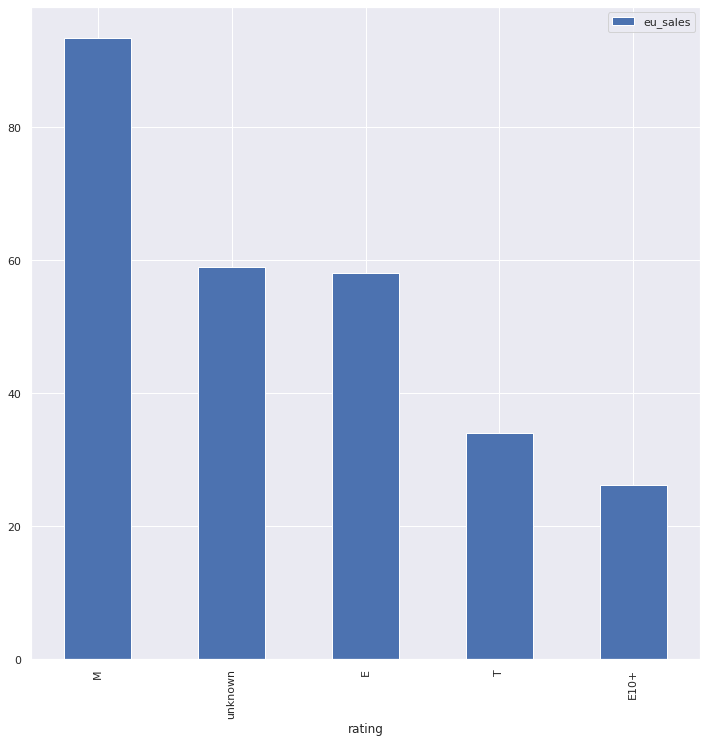

In [43]:
actual_data.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).plot(y='eu_sales', kind='bar');

В Европе в целом ситуация такая же, незначительно отличается только количество проданных копий

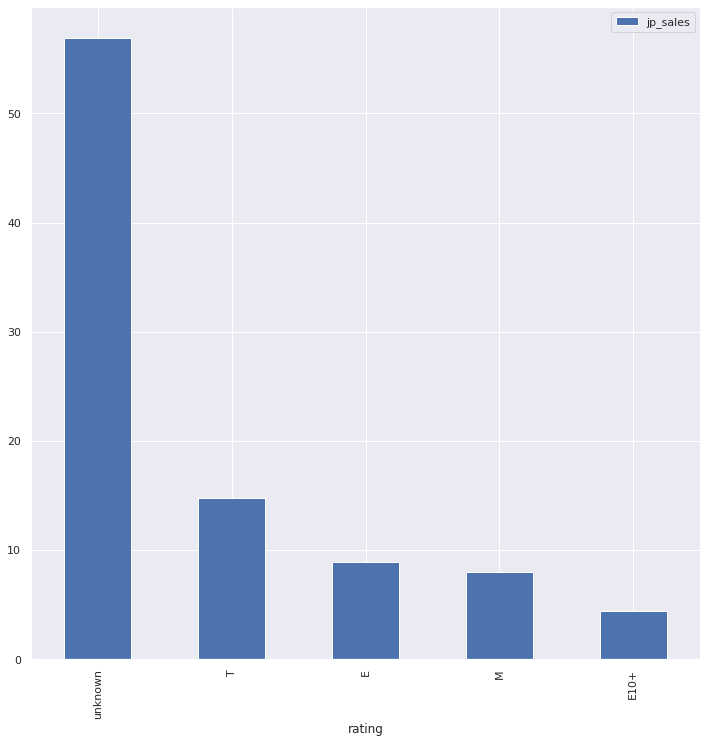

In [44]:
actual_data.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).plot(y='jp_sales', kind='bar');

К сожалению, в Японии больше всего продаж игр, возрастная категория которых не определена по каким-либо причинам. Однако по остаточным данным можем выдвинуть предположение, что игры для взрослых не так популярны, как игры для подростков и для любых возрастов

Вывод: в Северной Америке и Европе в целом похожая картинка по популярности платформ, не считая того, что в Америке на "XOne" всё-таки продаётся больше игр. При этом в Японии с большим отрывом лидирует платформа "3DS", которая заявила о себе ещё на рассмотрении диаграмм размаха, однако японский рынок не такой крупный, как Европа или Америка, поэтому в общем рейтинге платформа на 3-м месте по продажам. По жанрам в Америке и Европе ситуация также практически идентична: есть 2 лидера, меняющиеся местами. В Японии любовь приобрёл жанр RPG, который имеет свой неповторимый стиль и ценится, помимо самой Японии, и во всём мире. По категориям ESRB ситуация в Америке и Европе идентична: люди предпочитают игры с категорией "для взрослых". В Японии, скорее всего, опираются на другой рейтинг, так как продаж по рейтингу ESRB очень мало. Но при этом, опираясь на имеющиеся данные, можно предположить, что игры для всех возрастов и для подростков наиболее востребованы в данном регионе

### **5. Проверка гипотез**

**5.1 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**



Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC равны

Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не равны

Чтобы расчёт был произведён корректно, удалим пропуски в столбце с пользовательскими оценками 

In [45]:
actual_data = actual_data.dropna(subset=['user_score'])

In [46]:
x_one_score = actual_data.loc[actual_data['platform'] == 'XOne', 'user_score']
pc_score = actual_data.loc[actual_data['platform'] == 'PC', 'user_score']

alpha = 0.01

results = st.ttest_ind(x_one_score, pc_score, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
  print('Отвергаем нулевую гипотезу')
else:
  print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.11601398086668827
Не получилось отвергнуть нулевую гипотезу


Для наглядности проверим средние пользовательские оценки, чтобы подтвердить непротиворечивость нашей гипотезы

In [47]:
print(actual_data.loc[actual_data['platform'] == 'XOne', 'user_score'].mean())
actual_data.loc[actual_data['platform'] == 'PC', 'user_score'].mean()

6.594545454545456


6.298360655737705

Проверка гипотезы по выборкам показала, что вероятность равенства средних пользовательских оценок Xbox One и PC не выходит за рамки критерия значимости, а значит, вполне вероятно, что средние оценки пользователей по этим платформам равны, и гипотеза подтверждена

**5.2 Средние пользовательские рейтинги жанров Action и Sports разные**

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports равны

Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports разные

In [48]:
action_score = actual_data.loc[actual_data['genre'] == 'Action', 'user_score']
sports_score = actual_data.loc[actual_data['genre'] == 'Sports', 'user_score']

alpha = 0.01

results = st.ttest_ind(action_score, sports_score, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
  print('Отвергаем нулевую гипотезу')
else:
  print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


In [49]:
print(actual_data.loc[actual_data['genre'] == 'Action', 'user_score'].mean())
actual_data.loc[actual_data['genre'] == 'Sports', 'user_score'].mean()

6.760606060606061


5.2251968503937

Проверка гипотезы по выборкам показала, что вероятность равенства средних пользовательских оценок жанров Action и Sports вышла за рамки критерия значимости, а значит средние оценки пользователей по этим жанрам действительно разные, и гипотеза подтверждена

Вывод: проверяя данные гипотезы, мы получаем информацию, которая способна влиять на принятие бизнес-решений по выбору потенциально успешной стратегии для новой игры. Выбирая критерий значимости, мы ориентируемся на объём выборки и опыт статистического анализа. В данной ситуации, когда мы имеем дело с выборкой в сотни единиц, разумно использовать критерий значимости 0.01

### **6. Общий вывод**

В ходе исследования мы выделили актуальные данные по компьютерным играм и можем сделать выводы, которые помогут спрогнозировать успешность игры в 2017 году:

- самые прибыльные платформы: "PS4" и "XOne" - в Америке и Европе, в Японии - "3DS";

- самые популярные жанры: "Action" и "Shooter" - в Америке и Европе, "Role-playing" и "Action" - в Японии;

- самые популярные категории: "для взрослых" - в Америке и Европе, "для подростков" и "для всех возрастов" - в Японии, хотя этот регион стоит рассмотреть в рамках другого рейтинга возрастных категорий для получения более точных данных;

- на количество продаж влияют оценки критиков, но не пользователей;

- вполне вероятно, что средние рейтинги пользователей платформ Xbox One и PC одинаковые, а жанров Action и Sports - разные. Проверка данных гипотез и составление и проверка других позволят принять более взвешенные бизнес-решения при составлении стратегии успеха новой игры в 2017 году.

Мы определили, что самыми стабильно продаваемыми жанрами игр являются "Shooter" и "Sports". Так как шутеры наиболее популярны в Америке, логично рекламировать их там. Соответственно, выбирать самые популярные платформы и категорию игр в этом регионе.

Рекомендация для рекламного отдела:

Жанр - "Shooter"

Регион - Америка

Платформы - "PS4" и "XOne"

Рейтинг ESRB - "M"